<a href="https://colab.research.google.com/github/KaiserKyle/IST-718-Final-Project/blob/master/Data_Analysis_Who's_In.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # 2D plotting
from matplotlib.cbook import boxplot_stats
import seaborn as sns 

In [28]:
data = pd.read_csv('https://raw.githubusercontent.com/KaiserKyle/IST-718-Final-Project/master/agg_team_stats.csv' ,low_memory=False)
sos = pd.read_csv('https://raw.githubusercontent.com/KaiserKyle/IST-718-Final-Project/master/rpi_sos.csv')

data = data.drop(['name', 'market', 'alias','conf_id','division_alias','conf_name'], axis=1)
data = data.merge(sos, how='left', left_on=['team_id', 'season'], right_on=['id', 'season'])
data['win_perc'] = data.Win / (data.Win + data.Loss)
data = data.drop(['Win','Loss'], axis = 1)
data.fillna(0, inplace=True)
conf_encode = pd.get_dummies(data['conf_alias'])
data = pd.concat([data, conf_encode], axis = 1)
data['Pt_Diff'] = data.points_game - data.opp_points_game
data['Rebound_Diff'] = data.rebounds - data.opp_rebounds
data['Turnover_Diff'] = data.turnovers - data.opp_turnovers
data.head()

,season,team_id,conf_alias,points_game,field_goals_made,field_goals_att,field_goals_pct,three_points_made,three_points_att,three_points_pct,two_points_made,two_points_att,two_points_pct,blocked_att,free_throws_made,free_throws_att,free_throws_pct,offensive_rebounds,defensive_rebounds,rebounds,assists,turnovers,steals,blocks,assists_turnover_ratio,personal_fouls,ejections,foulouts,points,fast_break_pts,second_chance_pts,team_turnovers,points_off_turnovers,team_rebounds,flagrant_fouls,player_tech_fouls,team_tech_fouls,coach_tech_fouls,opp_points_game,opp_field_goals_pct,...,NonConf_SOS,RPI_Rank,RPI,id,win_perc,A10,AAC,ACC,AE,AS,BIG10,BIG12,BIGEAST,BIGSKY,BIGSOUTH,BIGWEST,COLONIAL,CUSA,HORIZON,IVY,MAAC,MAC,MEAC,MVC,MWC,NE,OVC,PAC12,PATRIOT,SEC,SOUTHERN,SOUTHLAND,SUMMIT,SUNBELT,SWAC,WAC,WCC,Pt_Diff,Rebound_Diff,Turnover_Diff
0,2013,8ddbfca9-a931-4908-aa31-9fcd17624b5f,CUSA,71.451613,22.25,60.500000,36.75,5.500000,16.000000,34.875000,16.750000,44.5,37.650000,5.000000,12.0,18.250000,64.85,13.500000,23.000000,36.500000,10.250000,15.000000,6.000000,2.250000,0.782500,18.750000,0.0,2.0,62.000000,5.000000,10.000000,0.75,10.750000,3.0,0.000000,0.75,0.0,0.0,71.645161,41.925,...,0.4989,151.0,0.5066,8ddbfca9-a931-4908-aa31-9fcd17624b5f,0.548387,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.193548,-1.000000,2.750000
1,2013,11a617d5-af03-4cce-bc8a-51114d9e41fe,BIGWEST,69.741935,23.20,59.200000,38.83,5.400000,19.600000,27.410000,17.800000,39.6,44.050000,2.900000,11.0,17.900000,59.79,10.500000,19.300000,29.800000,11.000000,11.900000,5.400000,2.000000,0.989000,18.400000,0.0,0.0,62.800000,6.555556,10.600000,0.30,10.900000,3.9,0.000000,0.00,0.0,0.0,70.580645,47.450,...,0.5984,166.0,0.4967,11a617d5-af03-4cce-bc8a-51114d9e41fe,0.451613,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.838710,-5.600000,0.400000
2,2013,d8217105-e9c2-4267-9538-3aaeea1ae167,MVC,69.393939,22.00,53.333333,41.65,4.666667,13.333333,35.916667,17.333333,40.0,43.733333,5.333333,11.0,17.166667,65.50,5.666667,21.666667,27.333333,13.333333,13.833333,4.333333,3.666667,1.013333,21.333333,0.0,0.0,59.666667,5.500000,6.833333,0.40,7.666667,4.8,0.166667,0.00,0.0,0.0,72.212121,43.350,...,0.4750,214.0,0.4784,d8217105-e9c2-4267-9538-3aaeea1ae167,0.424242,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,-2.818182,-11.166667,2.666667
3,2013,5016fe1a-9571-4d10-bf5b-b9c1b496bd57,WAC,77.228571,20.00,52.500000,37.50,4.000000,14.000000,26.750000,16.000000,38.5,41.150000,4.000000,14.0,20.000000,69.70,9.000000,13.500000,22.500000,10.500000,13.500000,6.000000,4.000000,0.840000,15.000000,0.0,0.0,58.000000,5.000000,7.500000,0.00,17.000000,3.5,0.500000,0.00,0.0,0.0,66.914286,50.150,...,0.5518,72.0,0.5611,5016fe1a-9571-4d10-bf5b-b9c1b496bd57,0.742857,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,10.314286,-14.500000,3.000000
4,2013,53aaac6a-796e-41a6-a04e-6ce74c5717f8,MEAC,65.281250,16.00,48.500000,32.75,7.000000,19.500000,34.500000,9.000000,29.0,31.200000,0.500000,21.5,30.000000,71.80,8.500000,22.500000,31.000000,12.000000,16.000000,2.500000,3.000000,0.790000,26.500000,0.0,0.0,60.500000,7.000000,7.000000,1.50,3.500000,4.5,0.000000,0.00,0.0,0.0,73.187500,47.450,...,0.4840,336.0,0.3801,53aaac6a-796e-41a6-a04e-6ce74c5717f8,0.281250,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-7.906250,-2.500000,6.500000


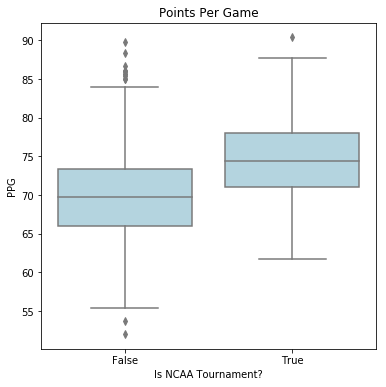

In [3]:
plt.rcParams['figure.figsize'] = [6, 6]
g = sns.boxplot(x="NCAA", y="points_game", data=data, color = "lightblue")
g.set(xlabel = "Is NCAA Tournament?", ylabel = "PPG")
g.set_title("Points Per Game")

plt.show()

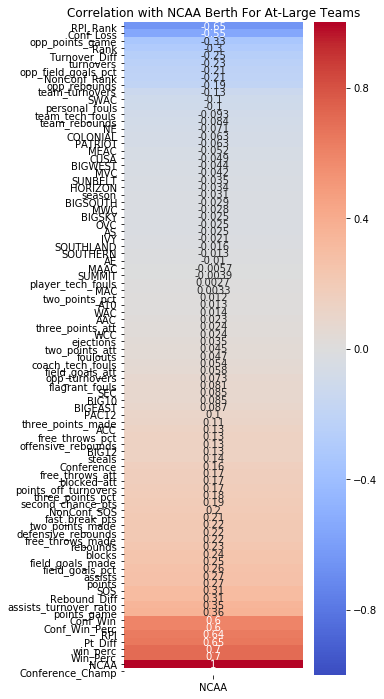

In [29]:
at_large_data = data[data.Conference_Champ == False]
in_teams = data[data.Conference_Champ == True]

plt.rcParams['figure.figsize'] = [4, 12]
corr = at_large_data.corr()
corr = corr.loc[['NCAA']].transpose().sort_values(by = 'NCAA')
g = sns.heatmap(corr, 
            yticklabels=corr.index.values,
            annot = True,
            center = 0,
            vmin = -1,
            vmax = 1,
            cmap = 'coolwarm')

plt.title("Correlation with NCAA Berth For At-Large Teams")

plt.show()

In [30]:
train_data = at_large_data[(at_large_data['season'] == 2013) | (at_large_data['season'] == 2014) | (at_large_data['season'] == 2015)]
test_data = at_large_data[(at_large_data['season'] == 2016) | (at_large_data['season'] == 2017)]

y_test = test_data[['NCAA', 'season', 'team_id', 'market']]
y_train = train_data[['NCAA', 'season', 'team_id', 'market']]
X_test = test_data.drop(['NCAA', 'season', 'team_id', 'conf_alias', 'id', 'market'], axis=1)
X_train = train_data.drop(['NCAA', 'season', 'team_id', 'conf_alias', 'id', 'market'], axis=1)

X_train.head()

,points_game,field_goals_made,field_goals_att,field_goals_pct,three_points_made,three_points_att,three_points_pct,two_points_made,two_points_att,two_points_pct,blocked_att,free_throws_made,free_throws_att,free_throws_pct,offensive_rebounds,defensive_rebounds,rebounds,assists,turnovers,steals,blocks,assists_turnover_ratio,personal_fouls,ejections,foulouts,points,fast_break_pts,second_chance_pts,team_turnovers,points_off_turnovers,team_rebounds,flagrant_fouls,player_tech_fouls,team_tech_fouls,coach_tech_fouls,opp_points_game,opp_field_goals_pct,opp_rebounds,opp_turnovers,Conference,...,NonConf_Rank,NonConf_SOS,RPI_Rank,RPI,win_perc,A10,AAC,ACC,AE,AS,BIG10,BIG12,BIGEAST,BIGSKY,BIGSOUTH,BIGWEST,COLONIAL,CUSA,HORIZON,IVY,MAAC,MAC,MEAC,MVC,MWC,NE,OVC,PAC12,PATRIOT,SEC,SOUTHERN,SOUTHLAND,SUMMIT,SUNBELT,SWAC,WAC,WCC,Pt_Diff,Rebound_Diff,Turnover_Diff
0,71.451613,22.25000,60.500000,36.750,5.500000,16.000000,34.875000,16.750000,44.50000,37.650000,5.000000,12.00000,18.250000,64.8500,13.500000,23.000000,36.500000,10.250000,15.000000,6.000000,2.250000,0.782500,18.750000,0.0,2.0,62.000000,5.000000,10.000000,0.75,10.750000,3.0,0.000000,0.750,0.0,0.0,71.645161,41.925000,37.50000,12.250000,True,...,172.0,0.4989,151.0,0.5066,0.548387,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.193548,-1.000000,2.750000
1,69.741935,23.20000,59.200000,38.830,5.400000,19.600000,27.410000,17.800000,39.60000,44.050000,2.900000,11.00000,17.900000,59.7900,10.500000,19.300000,29.800000,11.000000,11.900000,5.400000,2.000000,0.989000,18.400000,0.0,0.0,62.800000,6.555556,10.600000,0.30,10.900000,3.9,0.000000,0.000,0.0,0.0,70.580645,47.450000,35.40000,11.500000,True,...,8.0,0.5984,166.0,0.4967,0.451613,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.838710,-5.600000,0.400000
2,69.393939,22.00000,53.333333,41.650,4.666667,13.333333,35.916667,17.333333,40.00000,43.733333,5.333333,11.00000,17.166667,65.5000,5.666667,21.666667,27.333333,13.333333,13.833333,4.333333,3.666667,1.013333,21.333333,0.0,0.0,59.666667,5.500000,6.833333,0.40,7.666667,4.8,0.166667,0.000,0.0,0.0,72.212121,43.350000,38.50000,11.166667,True,...,242.0,0.4750,214.0,0.4784,0.424242,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,-2.818182,-11.166667,2.666667
4,65.281250,16.00000,48.500000,32.750,7.000000,19.500000,34.500000,9.000000,29.00000,31.200000,0.500000,21.50000,30.000000,71.8000,8.500000,22.500000,31.000000,12.000000,16.000000,2.500000,3.000000,0.790000,26.500000,0.0,0.0,60.500000,7.000000,7.000000,1.50,3.500000,4.5,0.000000,0.000,0.0,0.0,73.187500,47.450000,33.50000,9.500000,True,...,220.0,0.4840,336.0,0.3801,0.281250,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-7.906250,-2.500000,6.500000
5,65.156250,22.96875,53.562500,43.025,5.812500,18.093750,32.156250,17.156250,35.46875,48.706250,3.906250,13.40625,20.843750,65.2375,7.968750,22.500000,30.468750,12.781250,11.031250,6.500000,3.968750,1.291875,18.125000,0.0,0.0,65.156250,7.178571,8.000000,0.25,13.437500,3.0,0.031250,0.125,0.0,0.0,63.437500,40.409375,32.96875,13.125000,True,...,255.0,0.4699,148.0,0.5079,0.531250,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1.718750,-2.500000,-2.093750


In [0]:
from sklearn import linear_model
clf = linear_model.SGDClassifier(max_iter=1000)
clf.fit(X_train, y_train.NCAA)
clf.score(X_test, y_test.NCAA)

0.8411214953271028

In [0]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(X_train, y_train.NCAA)
clf.score(X_test, y_test.NCAA)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.660436137071651

In [0]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train.NCAA)
neigh.score(X_test, y_test.NCAA)

0.8286604361370716

In [48]:
from numpy.random import seed
seed(2)

from sklearn.ensemble import RandomForestClassifier 

forest = RandomForestClassifier(n_estimators = 500)
forest.fit(X_train, y_train.NCAA)
print('Random Forest Score: ', forest.score(X_test, y_test.NCAA))

predictions = pd.DataFrame(forest.predict_proba(X_test))

predictions['Actual'] = y_test.NCAA.values
predictions['season'] = y_test.season.values
predictions['Team_Name'] = y_test.market.values
predictions['team_id'] = y_test.team_id.values
predictions.sort_values(by = 1, ascending = False, inplace = True)

pred_2016 = predictions[predictions['season'] == 2016]
pred_2017 = predictions[predictions['season'] == 2017]

in_2016 = pred_2016.head(36)
in_2017 = pred_2017.head(36)

print("2016 Top 36 at-large bid accuracy: ", in_2016.Actual.mean())
print("2017 Top 36 at-large bid accuracy: ", in_2017.Actual.mean())

Random Forest Score:  0.8495297805642633
2016 Top 36 at-large bid accuracy:  1.0
2017 Top 36 at-large bid accuracy:  0.9722222222222222


In [52]:
conf_champ_2016 = in_teams[in_teams.season == 2016]
conf_champ_2016 = conf_champ_2016[['season', 'team_id', 'market']]
conf_champ_2016 = conf_champ_2016.rename(index=str, columns={"market": "Team_Name"})


full_predictions_2016 = pd.concat([conf_champ_2016, in_2016])
full_predictions_2016 = full_predictions_2016[['Team_Name','season','team_id']]

conf_champ_2017 = in_teams[in_teams.season == 2017]
conf_champ_2017 = conf_champ_2017[['season', 'team_id', 'market']]
conf_champ_2017 = conf_champ_2017.rename(index=str, columns={"market": "Team_Name"})


full_predictions_2017 = pd.concat([conf_champ_2017, in_2017])
full_predictions_2017 = full_predictions_2017[['Team_Name','season','team_id']]

full_predictions_2016.to_csv("predicted_2016.csv", index = False)
full_predictions_2017.to_csv("predicted_2017.csv", index = False)

from google.colab import files 
files.download('predicted_2016.csv')
files.download('predicted_2017.csv')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [35]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)


from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.preprocessing import StandardScaler

print(X_train.shape)

def create_baseline():
	# create model
  model = Sequential()
  model.add(Dense(87, input_dim=87, kernel_initializer='normal', activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(50, kernel_initializer='normal', activation='softmax'))
  model.add(Dropout(0.5))
  model.add(Dense(30, kernel_initializer='normal', activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
	# Compile model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test)

X_train_scale

(961, 87)


Using TensorFlow backend.


array([[ 0.23649742, -0.43131629,  0.77379028, ..., -0.09382445,
        -0.01098564,  0.7755782 ],
       [-0.06714247, -0.13877186,  0.56076152, ..., -0.20215186,
        -0.78605474, -0.18487323],
       [-0.12894681, -0.50830166, -0.40059903, ..., -0.53452004,
        -1.72400068,  0.74151964],
       ...,
       [ 1.04429409,  0.77478793,  0.88849807, ..., -0.50907951,
        -0.33112288,  0.06034841],
       [ 0.55454674,  0.9474218 ,  0.69682184, ...,  0.30501737,
         1.46460705,  0.03557855],
       [ 1.22711832,  0.75969276,  0.69667579, ...,  1.46959492,
         0.3012225 , -0.43249901]])

In [36]:
%%time

model = create_baseline()

# FIT THE MODEL
history  = model.fit(X_train_scale, y_train.NCAA, validation_data=(X_test_scale, y_test.NCAA), epochs=500, batch_size=10000, verbose=2)

# EVALUATE THE MODEL
scores = model.evaluate(X_test_scale, y_test.NCAA, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))


W0614 23:27:53.229221 140478485067648 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0614 23:27:53.233651 140478485067648 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0614 23:27:53.248872 140478485067648 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0614 23:27:53.272301 140478485067648 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0614 23:27:53.285470 14

Train on 961 samples, validate on 638 samples
Epoch 1/500
 - 1s - loss: 0.6934 - acc: 0.4058 - val_loss: 0.6931 - val_acc: 0.6646
Epoch 2/500
 - 0s - loss: 0.6931 - acc: 0.4828 - val_loss: 0.6928 - val_acc: 0.6646
Epoch 3/500
 - 0s - loss: 0.6929 - acc: 0.5765 - val_loss: 0.6924 - val_acc: 0.6646
Epoch 4/500
 - 0s - loss: 0.6927 - acc: 0.6285 - val_loss: 0.6921 - val_acc: 0.6646
Epoch 5/500
 - 0s - loss: 0.6923 - acc: 0.6327 - val_loss: 0.6918 - val_acc: 0.6646
Epoch 6/500
 - 0s - loss: 0.6920 - acc: 0.6316 - val_loss: 0.6914 - val_acc: 0.6646
Epoch 7/500
 - 0s - loss: 0.6918 - acc: 0.6316 - val_loss: 0.6910 - val_acc: 0.6646
Epoch 8/500
 - 0s - loss: 0.6914 - acc: 0.6316 - val_loss: 0.6907 - val_acc: 0.6646
Epoch 9/500
 - 0s - loss: 0.6912 - acc: 0.6316 - val_loss: 0.6903 - val_acc: 0.6646
Epoch 10/500
 - 0s - loss: 0.6908 - acc: 0.6316 - val_loss: 0.6899 - val_acc: 0.6646
Epoch 11/500
 - 0s - loss: 0.6905 - acc: 0.6316 - val_loss: 0.6895 - val_acc: 0.6646
Epoch 12/500
 - 0s - loss: 0

In [37]:
y_hat = model.predict_proba(X_test_scale)

predictions = pd.DataFrame(y_hat)

predictions['Actual'] = y_test.NCAA.values
predictions['Season'] = y_test.season.values
predictions['Team'] = y_test.team_id.values

predictions.sort_values(by = 0, ascending = False, inplace = True)

#print(predictions.head(75))

pred_2016 = predictions[predictions['Season'] == 2016]
pred_2017 = predictions[predictions['Season'] == 2017]

in_2016 = pred_2016.head(36)
in_2017 = pred_2017.head(36)

print("2016 Top 36 at-large bids correct: ", in_2016.Actual.sum())
print("2017 Top 36 at-large bids correct: ", in_2017.Actual.sum())

2016 Top 36 at-large bids correct:  33
2017 Top 36 at-large bids correct:  29
